In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 1. Load dataset
df = pd.read_csv(r"C:\Users\maher\Desktop\StudentPerformanceFactors.csv")

In [12]:
# 2. Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

if "Exam_Score" in num_cols:
    num_cols.remove("Exam_Score")

In [13]:
# 3. Preprocessing
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


In [14]:
# 4. Features & Target
X = df.drop(columns=["Exam_Score"])
y = df["Exam_Score"]

In [15]:
# 5. Transform and convert to DataFrame
X_processed = preprocessor.fit_transform(X)
processed_feature_names = (
    num_cols +
    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols))
)

X_df = pd.DataFrame(
    X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
    columns=processed_feature_names
)


In [9]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 6. Feature engineering example
if 'Hours_Studied' in X_df.columns and 'Motivation_Level' in X_df.columns:
    X_df['Study_Motivation'] = X_df['Hours_Studied'] * X_df['Motivation_Level']

# Log transform skewed features
for col in X_df.columns:
    if (X_df[col] > 0).all():
        skew = X_df[col].skew()
        if abs(skew) > 1:
            X_df[col] = np.log1p(X_df[col])


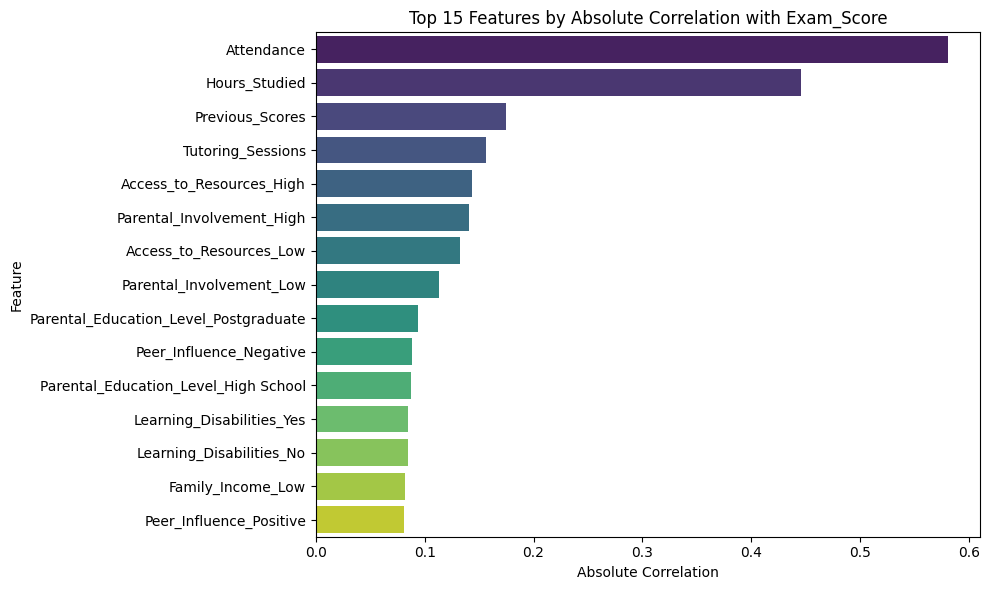

In [20]:
# Plot top 15 features without future warning
plt.figure(figsize=(10, 6))
sns.barplot(
    x="AbsCorrelation",
    y="Feature",
    hue="Feature",                 # Assign hue to match palette usage
    data=correlation.head(15),
    palette="viridis",
    legend=False                   # Remove extra legend
)
plt.title("Top 15 Features by Absolute Correlation with Exam_Score")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [21]:
# 7. Feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_df, y)
selected_feature_names = X_df.columns[selector.get_support()]
print("Selected features:", list(selected_feature_names))


Selected features: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions', 'Parental_Involvement_High', 'Parental_Involvement_Low', 'Access_to_Resources_High', 'Access_to_Resources_Low', 'Peer_Influence_Negative', 'Parental_Education_Level_Postgraduate']


In [22]:
# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)


In [23]:
# 9. Model evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return name, mae, rmse, r2

results = []

# --- Linear Regression ---
lin_reg = LinearRegression()
results.append(evaluate_model("Linear Regression", lin_reg, X_train, y_train, X_test, y_test))

# --- Polynomial Regression (degree=2) ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression()
results.append(evaluate_model("Polynomial Regression (deg=2)", poly_reg, X_train_poly, y_train, X_test_poly, y_test))



In [24]:
# 10. Print comparison
print("\nModel Comparison:")
print("{:<35} {:<10} {:<10} {:<10}".format("Model", "MAE", "RMSE", "R²"))
print("-" * 70)
for name, mae, rmse, r2 in results:
    print(f"{name:<35} {mae:<10.3f} {rmse:<10.3f} {r2:<10.3f}")


Model Comparison:
Model                               MAE        RMSE       R²        
----------------------------------------------------------------------
Linear Regression                   0.893      2.011      0.714     
Polynomial Regression (deg=2)       0.918      2.030      0.709     
